In [140]:
import pickle
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import cupy as cp
from cupyx.scipy import ndimage
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from sklearn.model_selection import cross_val_score

# Configs

In [2]:
pad = 1000
org_rad = 75 
org_pad = 25
# seq gen configs
n_init_orgs = 10
n_total_orgs = 6
n_search = 30
size = 3000 
# sim anneal configs
niter = 1000
move_len = 25
move_decay = 1
random_perturb = 1/5
perturb_decay = .9975

# Model

In [3]:
model_sigmas = [200, 700]
feats_ixs = np.array([0,1,1,0]).astype(np.bool8)
combined_df = pd.read_csv("datasets/round_1/combined/rnd0_and_1DF.csv")
feats_df = combined_df[['grad200','density700']]
scaler = MinMaxScaler()
X = scaler.fit_transform(feats_df.values)
y = combined_df.cdx2Dipole.values
model = KernelRidge(kernel="rbf").fit(X, y)

# Functions

In [10]:
def max_gradient(localIm):
    x, y = org_rad, org_rad

    # get pixel intensities in extremes
    xmax = localIm[x + org_rad - 1, y]
    xmin = localIm[x - org_rad, y]
    ymax = localIm[x, y + org_rad - 1]
    ymin = localIm[x, y - org_rad]

    xdiffnorm  = (xmax - xmin) / org_rad 
    ydiffnorm = (ymax - ymin) / org_rad

    # gradient magnitude and vector
    grad = np.array(np.sqrt(xdiffnorm**2 + ydiffnorm**2))
    gradVec = np.array((xdiffnorm, ydiffnorm))
                   
    return grad, gradVec

def extract_features(image, sigma, centroids):
    # gaussian blur
    im = cp.array(image)
    im_blur = ndimage.gaussian_filter(im, sigma=sigma, mode = 'constant')
    
    # extract features per centroid
    feats = []
    for _, (x, y) in enumerate(centroids):
        
        dfeats = im_blur[x-org_rad:x+org_rad, y-org_rad:y+org_rad]
        density = np.mean(dfeats.get())
        grad, _ = max_gradient(dfeats.get())
        feats.append((density, grad))
      
    return np.array(feats)

"""def random_location(image):
    found_valid = False
    
    while not found_valid:
        x, y = np.random.choice(size,2)
        xl, xr, yu, yd = x-org_rad, x+org_rad, y-org_rad, y+org_rad
        # ensure organoid is at least 2 pads worth away from wall and organoids
        min_rdist = org_rad + 2*org_pad
        if xl > min_rdist and yu > min_rdist and xr < size-min_rdist and yd < size-min_rdist:
            dim = len(image)
            xx, yy = np.mgrid[:min_rdist*2, :min_rdist*2]
            zz = (xx - min_rdist) ** 2 + (yy - min_rdist) ** 2
            circle = zz < min_rdist ** 2
            bool_mat = np.pad(circle, ((x-min_rdist, dim-x-min_rdist),(y-min_rdist, dim-y-min_rdist)))
            
            # check if overlapping with organoid
            if np.sum(image[bool_mat]) == 0: 
                found_valid = True
    return x,y"""

def random_location(image):
    found_valid = False
    
    while not found_valid:
        min_dist = 75 + 4*25
        x, y = np.random.choice(size, 2)
        # ensure organoid is at least 2 pads worth away from wall and organoids
        if x > min_dist and x < size-min_dist and y > min_dist and y < size-min_dist:
            bool_mat = draw_circle(x, y, image)
            
            # check if overlapping with other organoids
            if np.sum(image[bool_mat]) == 0: 
                found_valid = True
            else:
                print("collided")
        else:
            print("wall bump")
    return x,y

def evaluate(im_pattern, centroids):
    new_feats = []
    
    for sigma in model_sigmas:
        feats = extract_features(im_pattern, sigma, centroids)
        new_feats.append(feats[:, 0].reshape(-1,1))
        new_feats.append(feats[:, 1].reshape(-1,1))

    new_feats = np.hstack(new_feats)
    model_feats = new_feats[:, feats_ixs]
    model_feats_scaled = scaler.transform(model_feats)
    preds = model.predict(model_feats_scaled)

    reward = np.min(preds)
    # Alternative: preds.mean() - np.abs(np.max(preds) - np.min(preds))
    # Alternative: preds.mean() - np.sqrt(np.var(preds))
    # Alternative: preds.mean()

    return reward, preds, model_feats_scaled

In [11]:
def generate_image():
   # print("Starting stochastic pattern generation...")
    # create empty pattern
    mask = np.zeros((size, size))
    centroids = []

    # Initialize mask
    for _ in range(n_init_orgs):
        x, y = random_location(mask)
        centroids.append((x,y))
        mask[x-org_rad:x+org_rad, y-org_rad:y+org_rad] = 255
    
    # Sequentially add organoids stochastically
    for _ in tqdm(range(n_total_orgs-1)):
        sim_organoids = []
        for _ in tqdm(range(n_search), leave = False):
            # copy to evaluate independently
            test_mask = mask.copy()
            test_centroids = centroids.copy()

            # sample test location in mask
            x, y = random_location(mask)
            test_centroids.append((x,y))
            test_mask[x-org_rad:x+org_rad, y-org_rad:y+org_rad] = 255
            objective, _, _ = evaluate(test_mask, test_centroids)
            sim_organoids.append((objective, x, y))
        
        # select best simulated organoid
        best_sim_organoid = sorted(sim_organoids)[-1]
        newx, newy = best_sim_organoid[1], best_sim_organoid[2]
        centroids.append((newx, newy))
        mask[newx-org_rad:newx+org_rad, newy-org_rad:newy+org_rad] = 255

    # add the pad at the end
    gen_pattern = np.pad(mask, pad)
    gen_centroids = np.array(centroids) + pad

    return gen_pattern, gen_centroids

# Circles

In [35]:
"""def draw_circle(x,y, mask):
    dim = len(mask)
    xx, yy = np.mgrid[:org_rad*2, :org_rad*2]
    zz = (xx - org_rad) ** 2 + (yy - org_rad) ** 2
    circle = zz < org_rad ** 2
    print(x,y)
    
    bool_mat = np.pad(circle, ((x-org_rad, dim-x-org_rad),(y-org_rad, dim-y-org_rad)))
    mask[bool_mat] = 255
    return mask"""


In [164]:
n_init_orgs = 5

(250, 250)
(150, 150)
(250, 250)
(150, 150)
(250, 250)
(150, 150)
(250, 250)
(150, 150)
(250, 250)
(150, 150)


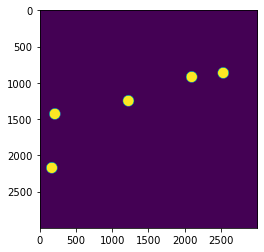

In [176]:
def draw_circle(x,y, orgIm, radius, fill = False, fillVal = 255):
    dim = len(orgIm)
    xx, yy = np.mgrid[:radius*2, :radius*2]
    zz = (xx - radius) ** 2 + (yy - radius) ** 2
    circle = zz < radius ** 2
    
    bool_mat = np.pad(circle, ((x-radius, dim-x-radius),(y-radius, dim-y-radius)))
    if fill:
        orgIm[bool_mat] = fillVal
        return orgIm
    else:
        return bool_mat

def random_location(image):
    found_valid = False
    
    while not found_valid:
        min_dist = 75 + 2*25
        x, y = np.random.choice(size, 2)
        # ensure organoid is at least 2 pads worth away from wall and organoids
        if x > min_dist and x < size-min_dist and y > min_dist and y < size-min_dist:
            bool_mat = draw_circle(x, y, image, min_dist)
            
            # check if overlapping with other organoids
            if np.sum(image[bool_mat]) == 0: 
                found_valid = True
    
    return x,y

mask = np.zeros((size, size))
centroids = []

# Initialize mask
for _ in range(n_init_orgs):
    x, y = random_location(mask)
    centroids.append((x,y))
    mask = draw_circle(x,y, mask, 75, fill = True)

plt.imshow(mask)
plt.show()

In [26]:
n_init_orgs

2

In [49]:
np.unique(mask)

array([False,  True])

# Circles Train DF

In [48]:
combined_df = pd.read_csv('datasets/round_1/combined/rnd0_and_1DF.csv')

In [71]:
temp_df = combined_df[combined_df.patternID == 0] 
temp_df

,dx,dy,fx,fy,patternID,grad100,density100,grad200,density200,grad300,...,density400,grad500,density500,grad600,density600,grad700,density700,grad800,density800,cdx2Dipole
0,600.0,2200.0,63.0,964.0,0.0,1.132232e-02,65.764062,0.064269,24.420757,0.042951,...,10.715852,0.014635,8.159314,0.010298,6.621515,0.008380,5.696046,0.007372,5.123668,18079.677541
1,600.0,2600.0,48.0,1182.0,0.0,1.132232e-02,65.764062,0.064266,24.420757,0.042799,...,10.735853,0.013012,8.213716,0.008662,6.714172,0.007203,5.837264,0.006696,5.314862,7383.694062
2,600.0,3800.0,68.0,1843.0,0.0,2.995911e-16,65.595890,0.000000,20.850809,0.000630,...,5.945228,0.006874,4.673831,0.008315,4.361317,0.008499,4.357222,0.008059,4.427853,34812.588025
3,800.0,5800.0,182.0,2800.0,0.0,2.995911e-16,65.595890,0.015802,21.412941,0.037989,...,9.792239,0.023601,8.083612,0.017365,6.944120,0.013910,6.269870,0.011830,5.899959,27538.671083
4,1000.0,8400.0,284.0,4164.0,0.0,1.599537e-05,65.596321,0.013057,21.390597,0.021131,...,7.765280,0.011941,5.870840,0.009797,4.820987,0.008209,4.175824,0.007058,3.749379,917.305838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,8400.0,1200.0,4069.0,366.0,0.0,4.861935e-01,81.191934,0.122561,34.063073,0.033688,...,10.531189,0.005778,7.043008,0.004153,5.200378,0.004133,4.193270,0.004407,3.630415,10291.886950
81,8400.0,1400.0,4087.0,468.0,0.0,4.861935e-01,81.191934,0.122561,34.063073,0.033669,...,10.547973,0.004498,7.110370,0.002742,5.332304,0.003563,4.383235,0.004359,3.860323,37812.380539
82,8400.0,5400.0,4136.0,2497.0,0.0,4.861935e-01,81.191934,0.122640,34.065005,0.036985,...,11.357917,0.016429,8.527596,0.013180,7.049116,0.010623,6.144075,0.008740,5.533781,36674.203154
83,8400.0,5600.0,4092.0,2673.0,0.0,4.861935e-01,81.191934,0.120831,34.125467,0.022134,...,12.628683,0.013246,9.756716,0.011622,8.015721,0.009683,6.860679,0.008147,6.067935,27775.107309


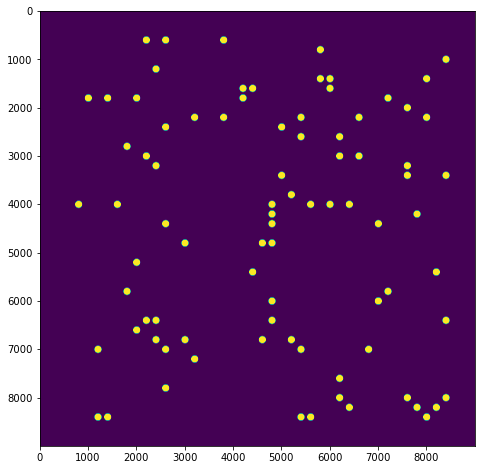

In [74]:
temp_df = combined_df[combined_df.patternID == 0] 
x, y = temp_df.dx.values.astype(int), temp_df.dy.values.astype(int)
centroids = np.array(list(zip(x,y)))

def circle_mask(centroids):
    mask = np.zeros((9000, 9000))

    # Initialize mask
    for x, y in centroids:
        mask = draw_circle(x,y, mask, 75, fill = True)

    return mask

mask = circle_mask(centroids)

plt.figure(figsize=(8,8))
plt.imshow(mask)
plt.show()

In [87]:
def max_gradient(localIm):
    x, y = org_rad, org_rad

    # get pixel intensities in extremes
    xmax = localIm[x + org_rad - 1, y]
    xmin = localIm[x - org_rad, y]
    ymax = localIm[x, y + org_rad - 1]
    ymin = localIm[x, y - org_rad]

    xdiffnorm  = (xmax - xmin) / org_rad 
    ydiffnorm = (ymax - ymin) / org_rad

    # gradient magnitude and vector
    grad = np.array(np.sqrt(xdiffnorm**2 + ydiffnorm**2))
    gradVec = np.array((xdiffnorm, ydiffnorm))
                   
    return grad, gradVec

def extract_features(sigma, centroids):
    mask = circle_mask(centroids)

    # gaussian blur
    im = cp.array(mask)
    im_blur = ndimage.gaussian_filter(im, sigma=sigma, mode = 'constant')
    
    # extract features per centroid
    feats = []
    gradVecs = []
    for _, (x, y) in enumerate(centroids):
        
        dfeats = im_blur[x-org_rad:x+org_rad, y-org_rad:y+org_rad]
        density = np.mean(dfeats.get())
        grad, grad_vec = max_gradient(dfeats.get())

        feats.append((x, y, grad, density))
        gradVecs.append(grad_vec)
      
    return im_blur.get(), mask, np.array(feats), gradVecs

In [92]:
sigBlurs, sigMasks, sigFeats, sigVecs = [], [], [], []
for sig in [100,200,300,400,500,600,700,800]: 
    blur, mask, feats, vecs = extract_features(sig, centroids)
    sigBlurs.append(blur)
    sigMasks.append(mask)
    sigFeats.append(feats)
    sigVecs.append(vecs)
    

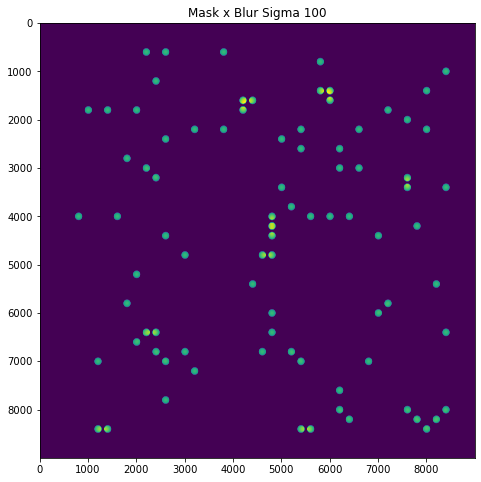

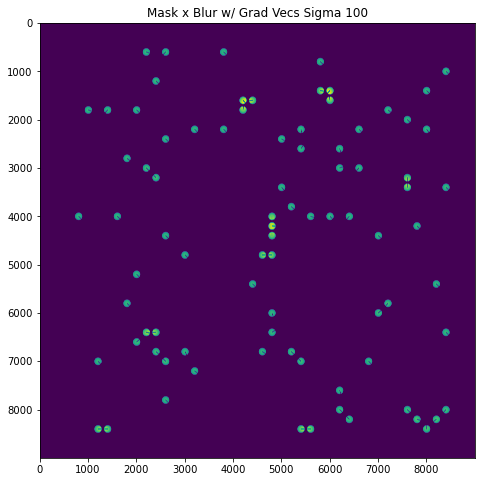

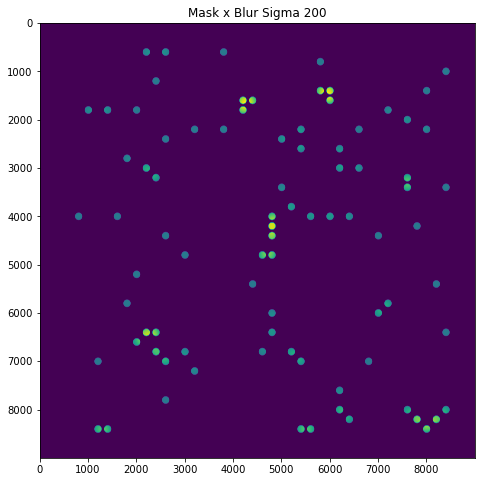

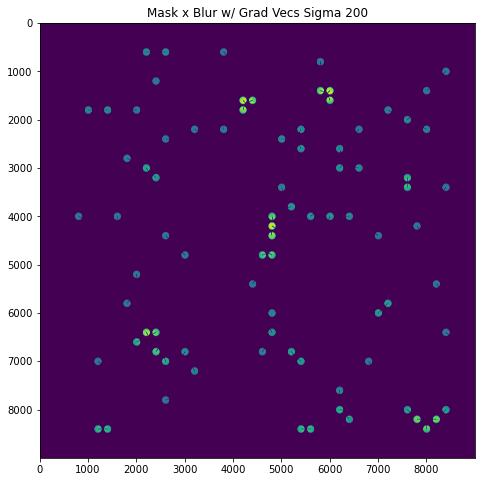

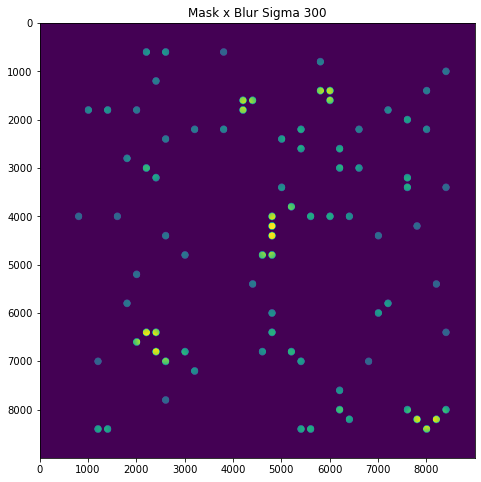

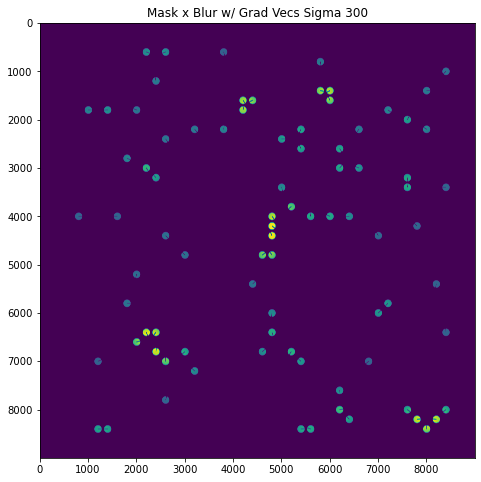

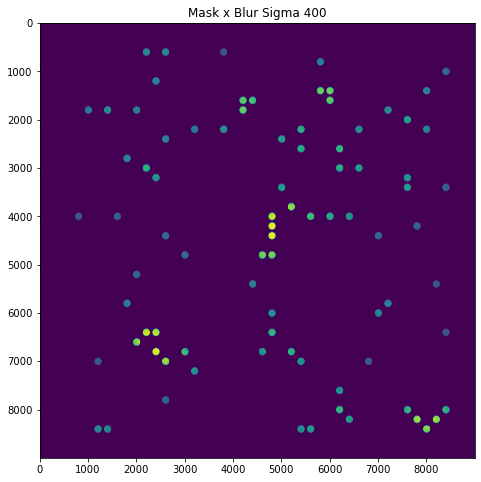

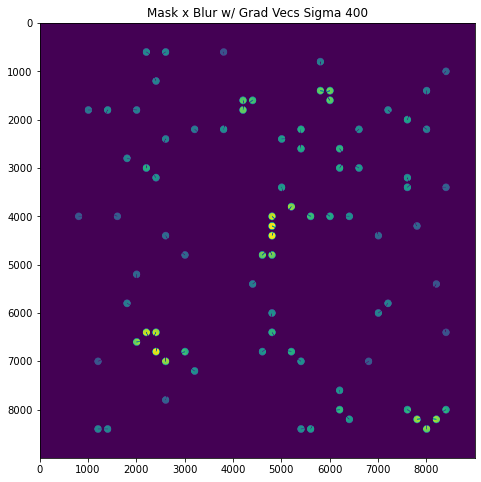

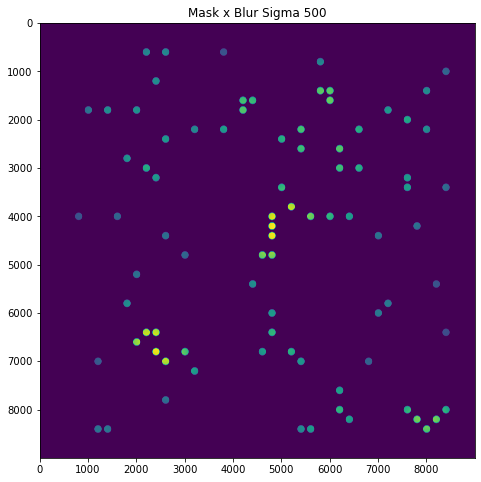

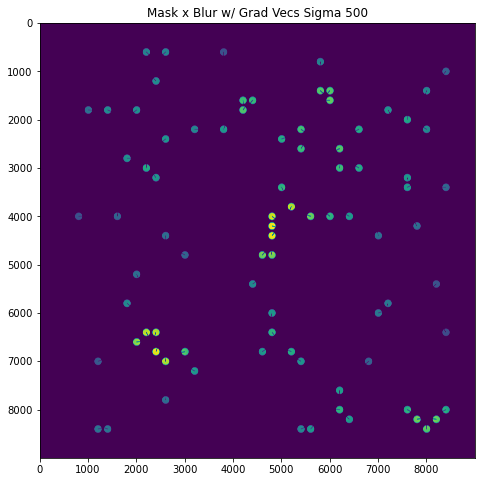

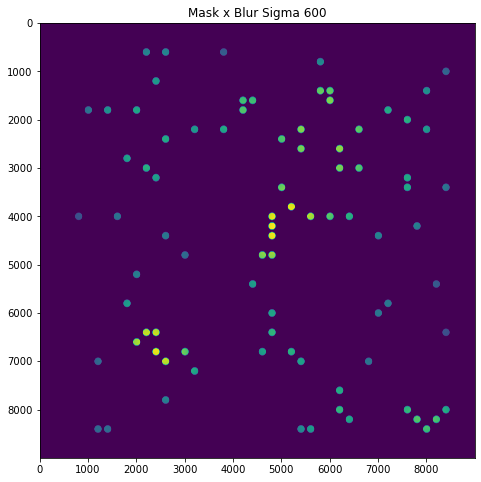

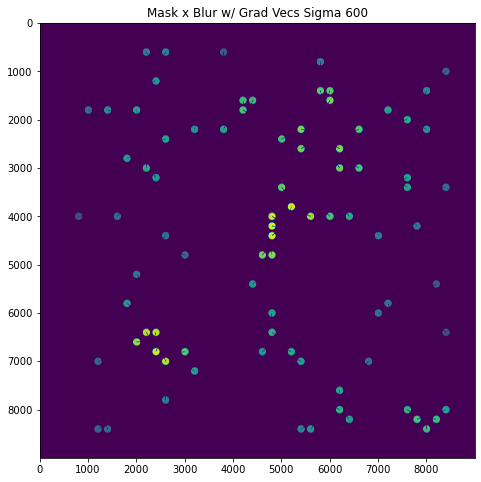

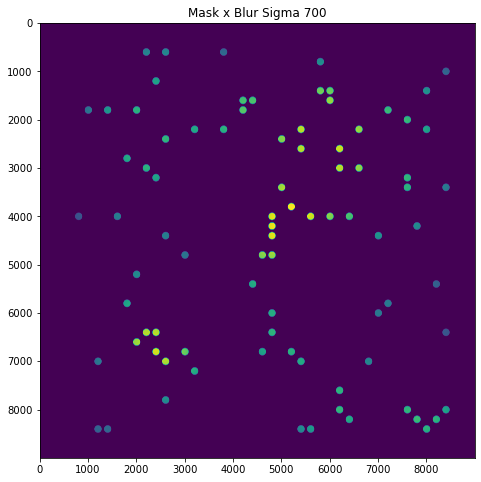

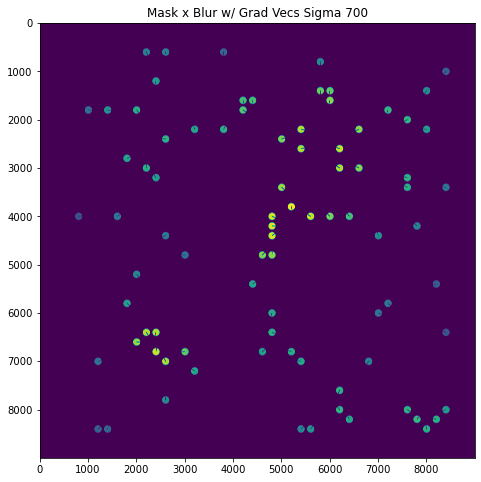

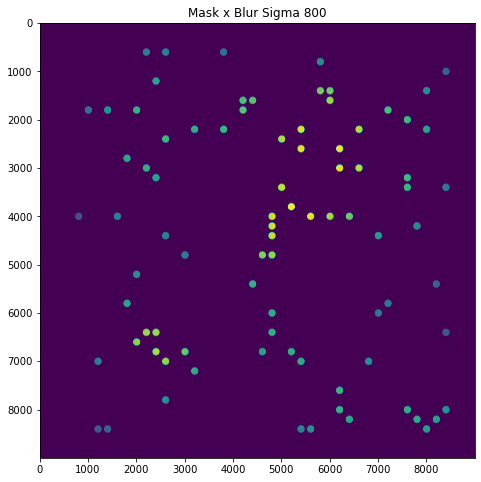

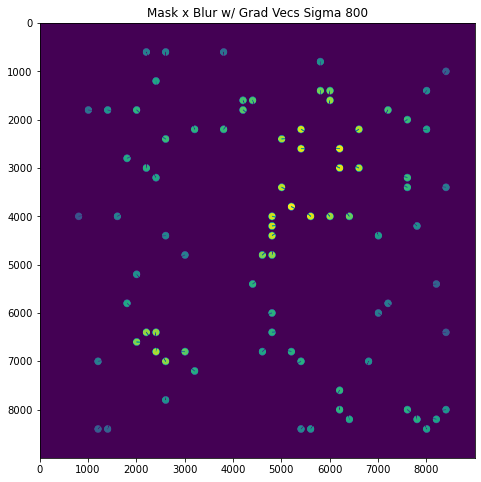

In [93]:

for sig in range(8):
    feats = sigFeats[sig]

    grad_vecs = sigVecs[sig]
    vecs = np.array(grad_vecs)
    norms = np.linalg.norm(vecs, axis = 1)
    vecNormed = vecs/norms.reshape(-1,1)

    blur = sigBlurs[sig]
    mask = sigMasks[sig]

    maskblur = blur*mask

    plt.figure(figsize=(8,8))
    plt.imshow(maskblur)
    plt.title("Mask x Blur Sigma %d" % (100*(sig+1)))
    plt.show()

    for grad, vec in zip(feats, vecNormed):
        for c in range(2, 81):
            newp = grad[:2] + c*vec
            vx = int(newp[0])
            vy = int(newp[1])
            maskblur[vx-5:vx+5, vy-5:vy+5] = 0


    plt.figure(figsize=(8,8))
    plt.imshow(maskblur)
    plt.title("Mask x Blur w/ Grad Vecs Sigma %d" % (100*(sig+1)))
    plt.show()

In [103]:
temp_df

,dx,dy,fx,fy,patternID,grad100,density100,grad200,density200,grad300,...,density400,grad500,density500,grad600,density600,grad700,density700,grad800,density800,cdx2Dipole
0,600.0,2200.0,63.0,964.0,0.0,1.132232e-02,65.764062,0.064269,24.420757,0.042951,...,10.715852,0.014635,8.159314,0.010298,6.621515,0.008380,5.696046,0.007372,5.123668,18079.677541
1,600.0,2600.0,48.0,1182.0,0.0,1.132232e-02,65.764062,0.064266,24.420757,0.042799,...,10.735853,0.013012,8.213716,0.008662,6.714172,0.007203,5.837264,0.006696,5.314862,7383.694062
2,600.0,3800.0,68.0,1843.0,0.0,2.995911e-16,65.595890,0.000000,20.850809,0.000630,...,5.945228,0.006874,4.673831,0.008315,4.361317,0.008499,4.357222,0.008059,4.427853,34812.588025
3,800.0,5800.0,182.0,2800.0,0.0,2.995911e-16,65.595890,0.015802,21.412941,0.037989,...,9.792239,0.023601,8.083612,0.017365,6.944120,0.013910,6.269870,0.011830,5.899959,27538.671083
4,1000.0,8400.0,284.0,4164.0,0.0,1.599537e-05,65.596321,0.013057,21.390597,0.021131,...,7.765280,0.011941,5.870840,0.009797,4.820987,0.008209,4.175824,0.007058,3.749379,917.305838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,8400.0,1200.0,4069.0,366.0,0.0,4.861935e-01,81.191934,0.122561,34.063073,0.033688,...,10.531189,0.005778,7.043008,0.004153,5.200378,0.004133,4.193270,0.004407,3.630415,10291.886950
81,8400.0,1400.0,4087.0,468.0,0.0,4.861935e-01,81.191934,0.122561,34.063073,0.033669,...,10.547973,0.004498,7.110370,0.002742,5.332304,0.003563,4.383235,0.004359,3.860323,37812.380539
82,8400.0,5400.0,4136.0,2497.0,0.0,4.861935e-01,81.191934,0.122640,34.065005,0.036985,...,11.357917,0.016429,8.527596,0.013180,7.049116,0.010623,6.144075,0.008740,5.533781,36674.203154
83,8400.0,5600.0,4092.0,2673.0,0.0,4.861935e-01,81.191934,0.120831,34.125467,0.022134,...,12.628683,0.013246,9.756716,0.011622,8.015721,0.009683,6.860679,0.008147,6.067935,27775.107309


In [101]:
circle_feats = np.hstack([sigFeats[i][:, 2:] for i in range(8)])


In [102]:
circle_feats.shape

(85, 16)

In [113]:
five_cols = temp_df.iloc[:, :5].columns.tolist()
rest_of_cols = temp_df.iloc[:, 5:].columns.tolist()

In [119]:
combined_df

,dx,dy,fx,fy,patternID,grad100,density100,grad200,density200,grad300,...,density400,grad500,density500,grad600,density600,grad700,density700,grad800,density800,cdx2Dipole
0,600.0,2200.0,63.0,964.0,0.0,1.132232e-02,65.764062,0.064269,24.420757,0.042951,...,10.715852,0.014635,8.159314,0.010298,6.621515,0.008380,5.696046,0.007372,5.123668,18079.677541
1,600.0,2600.0,48.0,1182.0,0.0,1.132232e-02,65.764062,0.064266,24.420757,0.042799,...,10.735853,0.013012,8.213716,0.008662,6.714172,0.007203,5.837264,0.006696,5.314862,7383.694062
2,600.0,3800.0,68.0,1843.0,0.0,2.995911e-16,65.595890,0.000000,20.850809,0.000630,...,5.945228,0.006874,4.673831,0.008315,4.361317,0.008499,4.357222,0.008059,4.427853,34812.588025
3,800.0,5800.0,182.0,2800.0,0.0,2.995911e-16,65.595890,0.015802,21.412941,0.037989,...,9.792239,0.023601,8.083612,0.017365,6.944120,0.013910,6.269870,0.011830,5.899959,27538.671083
4,1000.0,8400.0,284.0,4164.0,0.0,1.599537e-05,65.596321,0.013057,21.390597,0.021131,...,7.765280,0.011941,5.870840,0.009797,4.820987,0.008209,4.175824,0.007058,3.749379,917.305838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2368,8375.0,3575.0,4227.0,1848.0,15.0,2.165474e-03,65.635875,0.039018,23.551875,0.037631,...,14.198074,0.027236,12.556588,0.020807,11.198842,0.016307,10.189064,0.013471,9.497106,5816.722445
2369,8375.0,6975.0,3974.0,3646.0,15.0,1.272793e-01,69.343982,0.068616,31.373351,0.007196,...,15.796296,0.012764,13.436115,0.013936,11.976458,0.014348,11.034034,0.014293,10.411812,71005.978903
2370,8575.0,1175.0,4387.0,564.0,15.0,2.161424e-03,65.635875,0.042423,23.036778,0.032925,...,10.632671,0.018641,8.770789,0.014859,7.522419,0.012525,6.694951,0.011084,6.161130,9403.750582
2371,8575.0,6175.0,4201.0,3125.0,15.0,2.995911e-16,65.595890,0.013713,21.539230,0.030831,...,10.823731,0.024468,10.041820,0.021799,9.751673,0.019908,9.626664,0.018135,9.528567,22410.032842


In [122]:
patternID = np.unique(combined_df.patternID.values)
allIDs = []
for id in patternID:
    temp_df = combined_df[combined_df.patternID == id] 
    centroids = temp_df.values[:, :2].astype(int)

    sigBlurs, sigMasks, sigFeats, sigVecs = [], [], [], []
    for sig in [100,200,300,400,500,600,700,800]: 
        _, _, feats, _ = extract_features(sig, centroids)
        assert(np.all(feats[:, :2] == centroids))
        sigFeats.append(feats[:, 2:])

    featsStacked = np.hstack(sigFeats)
    dfID = np.hstack([temp_df.values[:, :5], featsStacked])
    allIDs.append(dfID)

In [133]:
circle_combined_df = np.hstack([np.vstack(allIDs), combined_df.values[:, -1].reshape(-1,1)])

In [136]:
circle_combined_df = pd.DataFrame(circle_combined_df, columns= combined_df.columns)
circle_combined_df.to_csv("circle_combined_df.csv", index = False)

# Circle Modeling

In [137]:
X, y = circle_combined_df.values[:, 5:-1], circle_combined_df.values[:, -1]

In [139]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [151]:
feat_names = circle_combined_df.iloc[:, 5:-1].columns.values

In [152]:
# prediciting on single degree variables
estimator = KernelRidge(kernel="rbf")

for n in range(1, 6):
    sfs = SequentialFeatureSelector(estimator, n_features_to_select=n, scoring="neg_root_mean_squared_error")
    sfs.fit(X_scaled, y)
    select_df = X_scaled[:, sfs.get_support()]
    scores = cross_val_score(estimator, select_df, y, cv=5, scoring="neg_root_mean_squared_error")
    print(scores.mean(), feat_names[sfs.get_support()])

-67965.34377027293 ['density700']
-66844.3719628572 ['grad200' 'density700']
-66764.86142872235 ['density100' 'grad200' 'density700']
-66773.32421654541 ['density100' 'grad200' 'density700' 'density800']
-66736.83413175495 ['grad100' 'density100' 'grad200' 'density700' 'density800']


In [159]:
# prediciting on single degree variables
estimator = KernelRidge(kernel="rbf")
sfs = SequentialFeatureSelector(estimator, n_features_to_select=2, scoring="neg_root_mean_squared_error")
sfs.fit(X_scaled, y)
select_df = X_scaled[:, sfs.get_support()]

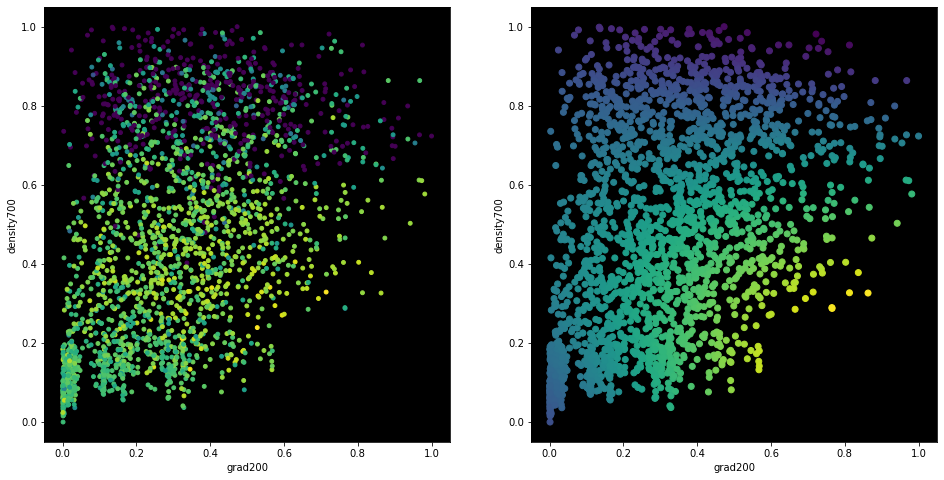

In [163]:
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.scatter(select_df[:, 0], select_df[:, 1], c = np.log1p(y), s = 15)
plt.xlabel("grad200")
plt.ylabel("density700")
plt.gca().set_facecolor((0,0,0))

estimator = KernelRidge(kernel="rbf").fit(select_df, y)

plt.subplot(1,2,2)
plt.scatter(select_df[:, 0], select_df[:, 1], c = estimator.predict(select_df))
plt.xlabel("grad200")
plt.ylabel("density700")
plt.gca().set_facecolor((0,0,0))
plt.show()